# Tutorial 2

**Monday 17th of January**
- **Tutorial 2 - Part 1**: Natural chromaticity – MAD-X tracking module (groups of 3/4 students).
- **Tutorial 2 - Part 2**: Chromaticity correction – impact of non-linearities (groups of 3/4 students).
- **Tutorial 2 - Part 3**: Design of a transfer line  - optics and matching (groups of 3/4 students).

$\color{red}{\text{Homework + Tutorial 2 jupyter-notebooks}}$ (to be delivered as late on Wednesday 19th 18:00 to nuria.fuster@ific.uv.es). This will be considered as a BONUS to pass the accelerator design workshop oral exam. 


# Tutorial 2: Part 1

Objectives:

- Quantify the natural chromaticity of our FODO (Tutorial 1 - Part 3) cell.
- First tracking of particles.

**Natural chromaticity**
<div>
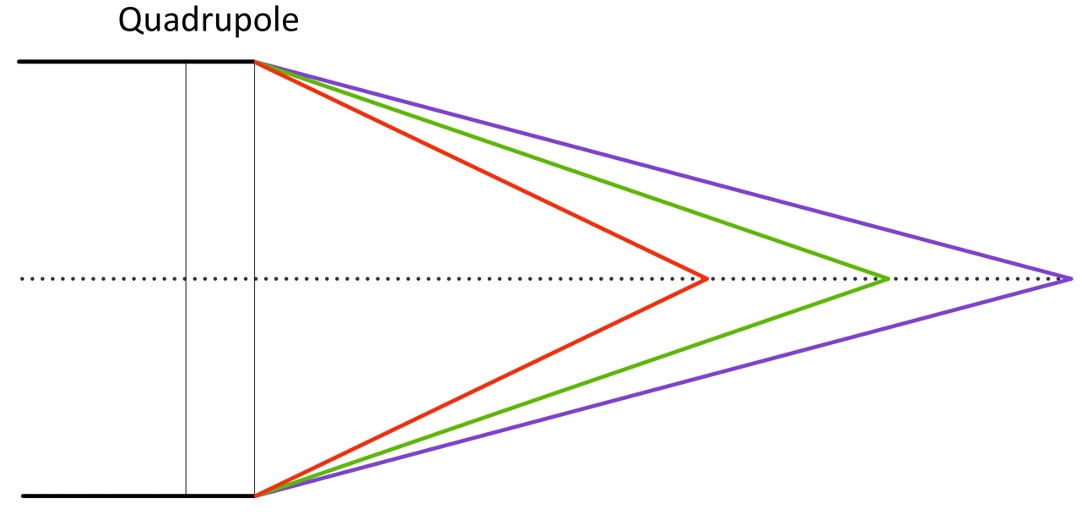
</div>


1. With a matching block adjust the tunes of the cell from Tutorial 1 - Part 3 to 0.25, both horizontal and vertical.


2. Using the chromaticities obtained from the TWISS, compute the tunes for particles with $\Delta p / p = 10^{-3}$.


3. Track a particle with initial coordinates x,y,px,py = (1,1,0,0) mm in 100 turns. Plot the x-px phase space. 

      **REMEMEBER** that in order to use the TRACK command you need to convert your lattice into a thin lattice. You will need the following commands:
    
        select, flag=MAKETHIN, SLICE=5;
        MAKETHIN, SEQUENCE=MY_SEQUENCE;
        use, sequence=MY_SEQUENCE;
        
    **It is important when defining the SEQUENCE to refer to the the center, to make it compatible with the makethin command! So you may need to re-define the s location in your sequence accordingly.**

    The track module to be use:
    
        track, dump;    
        start, x=1e-3, px=0, y=1e-3, py=0;    
        run, turns=100;   
        endtrack;

    **HINT**: In oder to access the track data using python you can print the output in a dataframe using the command: particle1=myMad.table['track.obs0001.p0001'].dframe(). If you have tracked two particles, the second particle output can be obtained via particle2=myMad.table['track.obs0002.p0002'].dframe().


4. How does the particle move in the phase space turn after turn? Do you see the tunes?

**BONUS:**

5. Track a particle with initial coordinates x,y,px,py=(100, 100, 0, 0) mm in 100 turns. Plot the x-px phase-space. Does something change with respect to the previous case? Why?


6. Repeat the tracking adding DELTAP=1e-2 to the track command. How does the phase space look now? Is the tune still same? It may help to look only at the first 4 turns to get a clearer picture.

        track, dump, DELTAP=1e-2;  


In [26]:
from matplotlib import pyplot as plt
%matplotlib notebook
import numpy as np
from cpymad.madx import Madx 

In [27]:
myMad = Madx(stdout=True)

# MATCHING THE TUNES

1. With a matching block adjust the tunes of the cell from Tutorial 1 - Part 3 to 0.25.


In [67]:
myMad = Madx()
myString='''

! *********************************************************************
! Definition of parameters
! *********************************************************************

quadrupoleLength=5;
dipoleLength=15;
cellLength=100;
nBend=736;

myKF=0.0056;
myKD=-0.0056;

! *********************************************************************
! Definition of magnets
! ********************************************************************* 

QF: quadrupole, L=quadrupoleLength, K1:=myKF;
QD: quadrupole, L=quadrupoleLength, K1:=myKD;
BM: sbend, L=dipoleLength, angle=2*pi/nBend; 

! *********************************************************************
! Definition of sequence
! *********************************************************************

myCell:sequence, refer=CENTER, L=cellLength; ! already changed to centre
q1: QF, at=2.5;
B1: BM, at =17.5;
B2: BM, at =37.5;
q2: QD, at=52.5;
B3: BM, at =67.5;
B4: BM, at =87.5;
endsequence;

! *********************************************************************
! Definition of beam
! *********************************************************************

beam, particle=proton, energy=7000;

! *********************************************************************
! Use of the sequence
! *********************************************************************
use, sequence=myCell;

! *********************************************************************
! TWISS BEFORE MATCHING
! *********************************************************************

twiss, table=beforematching, file="BeforeMatching.txt";
!plot, haxis=s, vaxis=betx,bety,dx,colour=100, title="BeforeMatching";

! *********************************************************************
! MATCHING
! *********************************************************************

MATCH, SEQUENCE=myCell;
GLOBAL, Q1=0.25;//H-tune
GLOBAL, Q2=0.25;//V-tune
VARY, NAME= myKF, STEP=0.00001;
VARY, NAME= myKD, STEP=0.00001;
LMDIF, CALLS=50, TOLERANCE=1e-6;//method adopted
ENDMATCH;

! *********************************************************************
! TWISS AFTER MATCHING
! *********************************************************************

twiss, file="AfterMatching.txt";
plot, haxis=s, vaxis=betx,bety,dx,colour=100, title="AfterMatching";

! *********************************************************************
! FINAL TUNE VALUES
! *********************************************************************

value, table(summ,Q1)*(nBend/4);
value, table(summ,Q2)*(nBend/4);

value, table(summ,dQ1);
value, table(summ,dQ2);

! MAKETHIN

select, flag=MAKETHIN, SLICE=1;
MAKETHIN, SEQUENCE=myCell;
use, sequence=myCell;

'''
myMad.input(myString);


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.07.00  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2021.05.03               +
  + Execution date: 2022.01.11 17:30:40      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               100                 -0    0.0006051853679        40.64955451 

                q1                dq1            betxmax              dxmax 
       0.236500685      -0.2917600666        160.5475138        2.444933737 

             dxrms             xcomax             xcorms                 q2 
       1.953527658                  0                  0       0.2363728498 

               dq2            betymax              dymax 

# Chromaticity
2. Using the chromaticities obtained from the TWISS, compute the tunes for $\Delta p / p = 10^{-3}$.

$\Delta Q = dq* \frac{\Delta p}{p}$


**REMEMBER** That the derivative functions in MAD-X are normalized by the relativistic factor beta.

We could assume ultra-relativistic beam.

In [68]:
beta_rel=myMad.sequence['mycell'].beam.beta
print (beta_rel)

0.9999999910167906


In [69]:
dq1_ref=myMad.table['summ'].dq1[0]
print(dq1_ref)

-0.3177280082808754


In [70]:
# Variation on the tune
dq1_ref*beta_rel*1e-3

-0.0003177280054266581

This detuning is quite important, this is something that we will more clear when tracking particles in the lattice.

In [71]:
#Tune of the machine
tune_onmomentum=myMad.table['summ'].q1[0]
print(tune_onmomentum)
tune_offmomentum=myMad.table['summ'].q1[0]-0.00031
print(tune_offmomentum)

0.25000012319209364
0.24969012319209363


# Tracking
3. Track a particle with initial coordinates x,y,px,py = (1,1,0,0) mm in 100 cells. Plot the x-px phase space. 

      **REMEMEBER** that in order to use the TRACK command you need to convert your lattice into a thin lattice. You will need the following commands:
    
        select, flag=MAKETHIN, SLICE=5;
        MAKETHIN, SEQUENCE=MY_SEQUENCE;
        use, sequence=MY_SEQUENCE;
        
    **It is important when defining the SEQUENCE to refer to the the center, to make it compatible with the makethin command! So you may need to re-define the s location in your sequence accordingly.**

    The track module to be use:
    
        track, dump;    
        start, x=1e-3, px=0, y=1e-3, py=0;    
        run, turns=100;   
        endtrack;

    **HINT**: In oder to access the track data using python you can print the output in a dataframe using the command: particle1=myMad.table['track.obs0001.p0001'].dframe(). If you have tracked two particles, the second particle output can be obtained via particle2=myMad.table['track.obs0002.p0002'].dframe().    

In [82]:
myString='''

! *********************************************************************
! Definition of parameters
! *********************************************************************

quadrupoleLength=5;
dipoleLength=15;
cellLength=100;
nBend=736;

myKF=0.0056;
myKD=-0.0056;

! *********************************************************************
! Definition of magnets
! ********************************************************************* 

QF: quadrupole, L=quadrupoleLength, K1:=myKF;
QD: quadrupole, L=quadrupoleLength, K1:=myKD;
BM: sbend, L=dipoleLength, angle=2*pi/nBend; 

! *********************************************************************
! Definition of sequence
! *********************************************************************

myCell:sequence, refer=CENTER, L=cellLength; ! already changed to centre
q1: QF, at=2.5;
B1: BM, at =17.5;
B2: BM, at =37.5;
q2: QD, at=52.5;
B3: BM, at =67.5;
B4: BM, at =87.5;
endsequence;

! *********************************************************************
! Definition of beam
! *********************************************************************

beam, particle=proton, energy=7000;

! *********************************************************************
! Use of the sequence
! *********************************************************************
use, sequence=myCell;

! *********************************************************************
! TWISS BEFORE MATCHING
! *********************************************************************

twiss, table=beforematching, file="BeforeMatching.txt";
!plot, haxis=s, vaxis=betx,bety,dx,colour=100, title="BeforeMatching";

! *********************************************************************
! MATCHING
! *********************************************************************

MATCH, SEQUENCE=myCell;
GLOBAL, Q1=0.25;//H-tune
GLOBAL, Q2=0.25;//V-tune
VARY, NAME= myKF, STEP=0.00001;
VARY, NAME= myKD, STEP=0.00001;
LMDIF, CALLS=50, TOLERANCE=1e-6;//method adopted
ENDMATCH;

! *********************************************************************
! TWISS AFTER MATCHING
! *********************************************************************

twiss, file="AfterMatching.txt";
plot, haxis=s, vaxis=betx,bety,dx,colour=100, title="AfterMatching";

! *********************************************************************
! FINAL TUNE VALUES
! *********************************************************************

value, table(summ,Q1)*(nBend/4);
value, table(summ,Q2)*(nBend/4);

value, table(summ,dQ1);
value, table(summ,dQ2);

!**********
! MAKETHIN
!**********

select, flag=MAKETHIN, SLICE=1;
MAKETHIN, SEQUENCE=myCell;
use, sequence=myCell;

!**********
! TRACKING
!**********

track,dump,file='linear_machine', DELTAP=0;
start, x= 1e-3, px=0, y= 1e-3, py=0;
run,turns=100;
endtrack;

value, table(SUMM, Q1);
value, table(SUMM, Q2);

'''
myMad.input(myString);

++++++ info: quadrupolelength redefined
++++++ info: dipolelength redefined
++++++ info: celllength redefined
++++++ info: nbend redefined
++++++ info: mykf redefined
++++++ info: mykd redefined
++++++ info: element redefined: qf
++++++ info: element redefined: qd
++++++ info: element redefined: bm
++++++ warning: implicit element re-definition ignored: q1
++++++ warning: implicit element re-definition ignored: b1
++++++ warning: implicit element re-definition ignored: b2
++++++ warning: implicit element re-definition ignored: q2
++++++ warning: implicit element re-definition ignored: b3
++++++ warning: implicit element re-definition ignored: b4
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               100                 -0    0.0005506879184        42.6135019

In [83]:
#When activating the option dump on the trck module  new table is generated by MADX with the tracking results
particle1=myMad.table['track.obs0001.p0001'].dframe()

In [84]:
particle1.head()

,number,turn,x,px,y,py,t,pt,s,e
#e,1.0,0.0,0.001000,0.000000e+00,0.001000,0.000000e+00,0.000000e+00,0.0,0.0,7000.0
#e,1.0,1.0,-0.002313,-3.997270e-05,0.000514,-3.999614e-05,1.901474e-05,0.0,0.0,7000.0
#e,1.0,2.0,-0.001000,7.657313e-09,-0.001000,7.631030e-09,6.517456e-05,0.0,0.0,7000.0
#e,1.0,3.0,0.002313,3.997270e-05,-0.000514,3.999614e-05,4.591911e-05,0.0,0.0,7000.0
#e,1.0,4.0,0.000999,-1.531463e-08,0.001000,-1.526206e-08,-3.250118e-07,0.0,0.0,7000.0


<IPython.core.display.Javascript object>


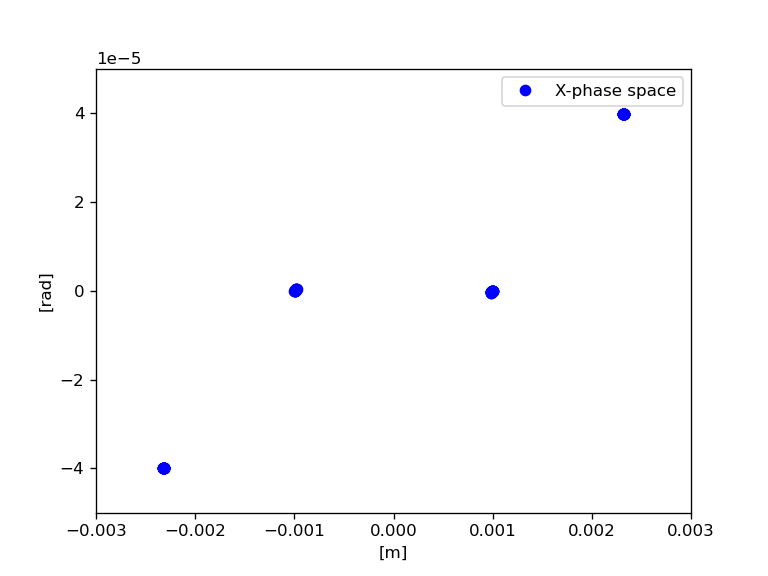

(-5e-05, 5e-05)

In [85]:
%matplotlib notebook
plt.plot(particle1['x'],particle1['px'],'ob',label='X-phase space')
#plt.plot(particle2['x'],particle2['px'],'or',label='X-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')
plt.xlim(-0.003,0.003)
plt.ylim(-5e-5, 5e-5)

<IPython.core.display.Javascript object>


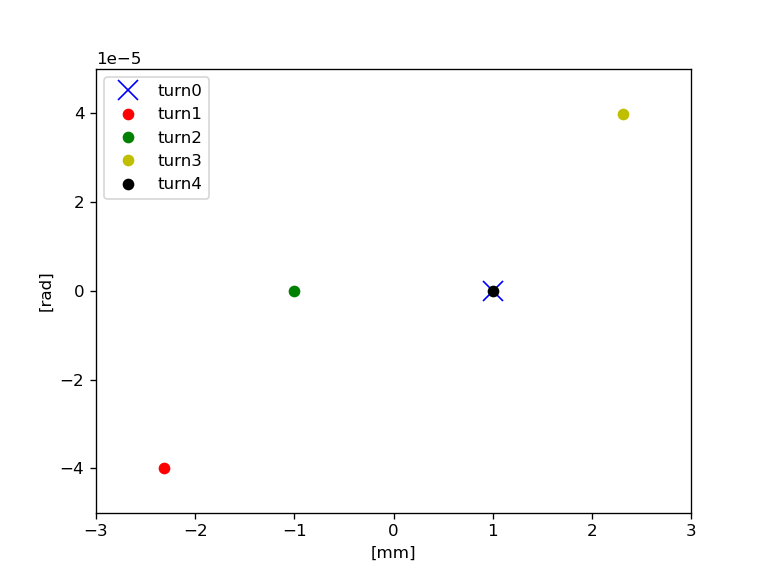

(-5e-05, 5e-05)

In [86]:
%matplotlib notebook
turn0=particle1[particle1["turn"]==0]
turn1=particle1[particle1["turn"]==1]
turn2=particle1[particle1["turn"]==2]
turn3=particle1[particle1["turn"]==3]
turn4=particle1[particle1["turn"]==4]
plt.plot(turn0['x']*1e3,turn0['px'],'xb',markersize=12,label='turn0')
plt.plot(turn1['x']*1e3,turn1['px'],'or',label='turn1')
plt.plot(turn2['x']*1e3,turn2['px'],'og',label='turn2')
plt.plot(turn3['x']*1e3,turn3['px'],'oy',label='turn3')
plt.plot(turn4['x']*1e3,turn4['px'],'ok',label='turn4')
plt.xlabel('[mm]')
plt.ylabel('[rad]')
plt.legend(loc='best')
plt.xlim(-3,3)
plt.ylim(-5e-5, 5e-5)

<IPython.core.display.Javascript object>


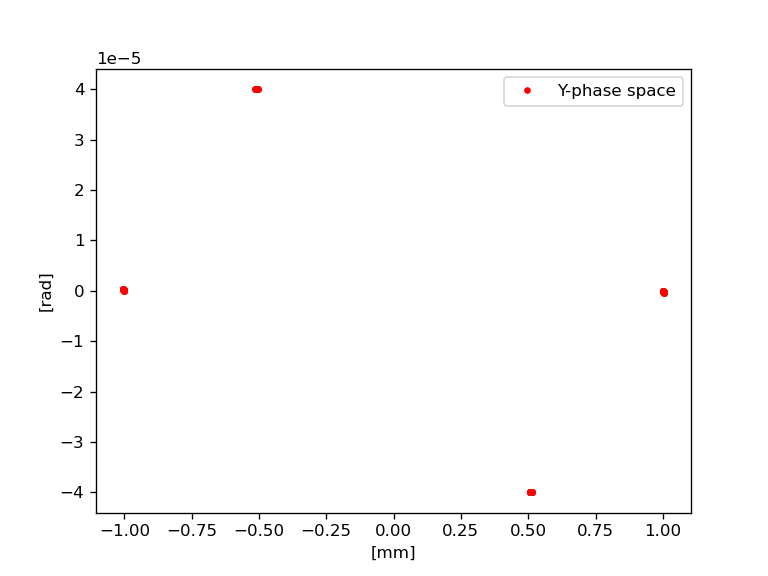

In [87]:
# Plot visualization options
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

plt.plot(particle1['y']*1e3,particle1['py'],'.r',label='Y-phase space')
plt.xlabel('[mm]')
plt.ylabel('[rad]')
plt.legend(loc='best')

<IPython.core.display.Javascript object>


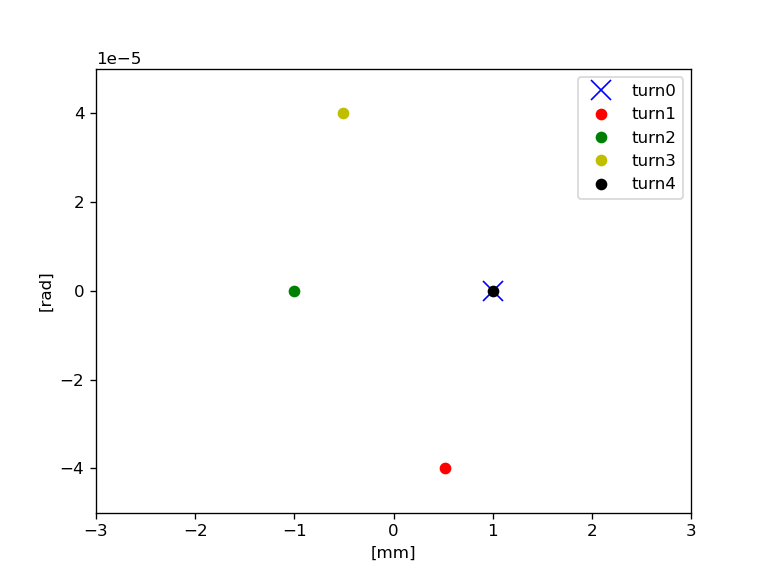

(-5e-05, 5e-05)

In [88]:
%matplotlib notebook
# Plot visualization options
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

turn0=particle1[particle1["turn"]==0]
turn1=particle1[particle1["turn"]==1]
turn2=particle1[particle1["turn"]==2]
turn3=particle1[particle1["turn"]==3]
turn4=particle1[particle1["turn"]==4]
plt.plot(turn0['y']*1e3,turn0['py'],'xb',markersize=12,label='turn0')
plt.plot(turn1['y']*1e3,turn1['py'],'or',label='turn1')
plt.plot(turn2['y']*1e3,turn2['py'],'og',label='turn2')
plt.plot(turn3['y']*1e3,turn3['py'],'oy',label='turn3')
plt.plot(turn4['y']*1e3,turn4['py'],'ok',label='turn4')
plt.xlabel('[mm]')
plt.ylabel('[rad]')
plt.legend(loc='best')
plt.xlim(-3,3)
plt.ylim(-5e-5, 5e-5)

# Traking particles with larger amplitude
5. Track a particle with initial coordinates x,y,px,py=(100, 100, 0, 0) mm in 100 cells. Plot the x-px phase-space. Does something change with respect to the previous case? Why?

In [89]:
myString='''
//*************************************************//
!   TRACKING
//*************************************************//

track,dump,file='linear_machine', DELTAP=0.00;
start, x= 1e-1, px=0, y= 1e-1, py=0;
run,turns=100;
endtrack;

'''
myMad.input(myString);

enter TRACK module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

Full 6D closed orbit search.
Initial value of 6-D closed orbit from Twiss: 
orbit0   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  Singular matrix occurred during closed orbit search.

6D closed orbit found by subroutine trclor 
iteration:   2 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: tracksumm

    number       turn                  x                 px 
         1          0                0.1                  0 
         1        100      0.09722293298   -4.787055974e-05 

                 y                 py                  t                 pt 
               0.1                  0                  0                  0 
      0.1006066085   -4.774676328e-05    

In [90]:
particle2=myMad.table['track.obs0001.p0001'].dframe()

<IPython.core.display.Javascript object>


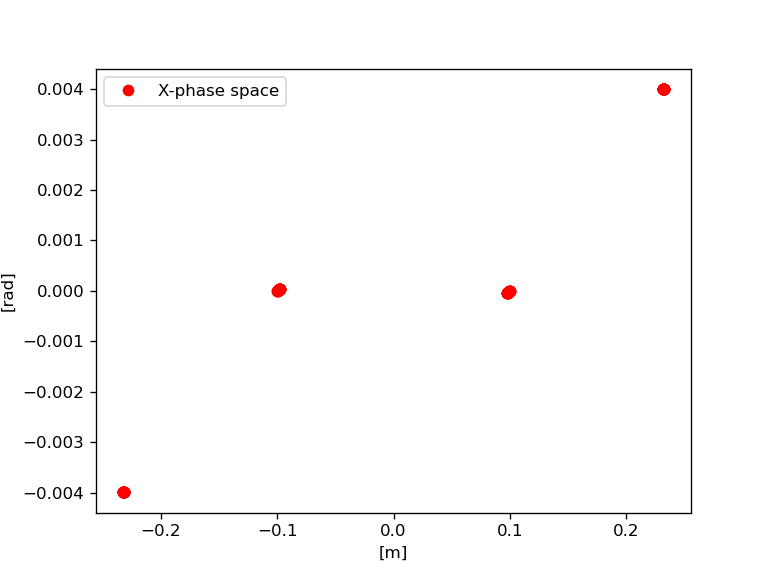

In [91]:
# Plot visualization options
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

#plt.plot(particle1['x'],particle1['px'],'ob',label='X-phase space')
plt.plot(particle2['x'],particle2['px'],'or',label='X-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')
#plt.xlim(-0.003,0.003)
#plt.ylim(-5e-5, 5e-5)

<IPython.core.display.Javascript object>


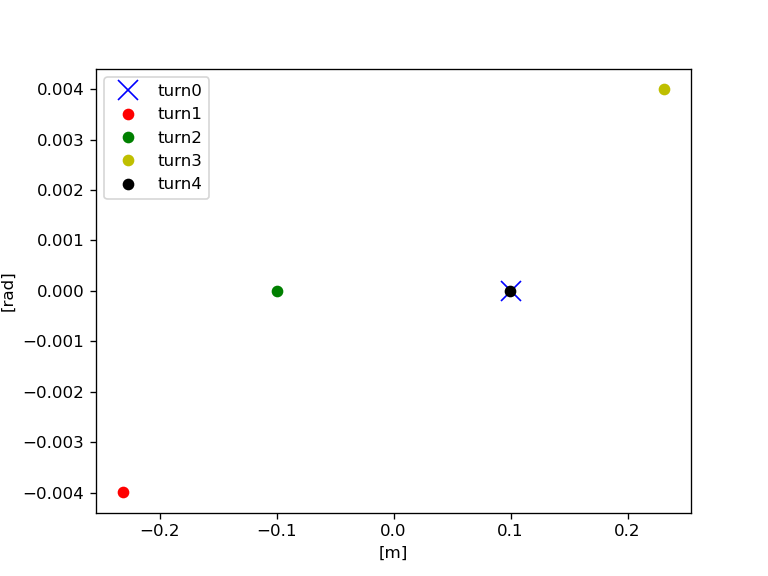

In [92]:
# Plot visualization options
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

turn0=particle2[particle2["turn"]==0]
turn1=particle2[particle2["turn"]==1]
turn2=particle2[particle2["turn"]==2]
turn3=particle2[particle2["turn"]==3]
turn4=particle2[particle2["turn"]==4]
plt.plot(turn0['x'],turn0['px'],'xb',markersize=12,label='turn0')
plt.plot(turn1['x'],turn1['px'],'or',label='turn1')
plt.plot(turn2['x'],turn2['px'],'og',label='turn2')
plt.plot(turn3['x'],turn3['px'],'oy',label='turn3')
plt.plot(turn4['x'],turn4['px'],'ok',label='turn4')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')

<IPython.core.display.Javascript object>


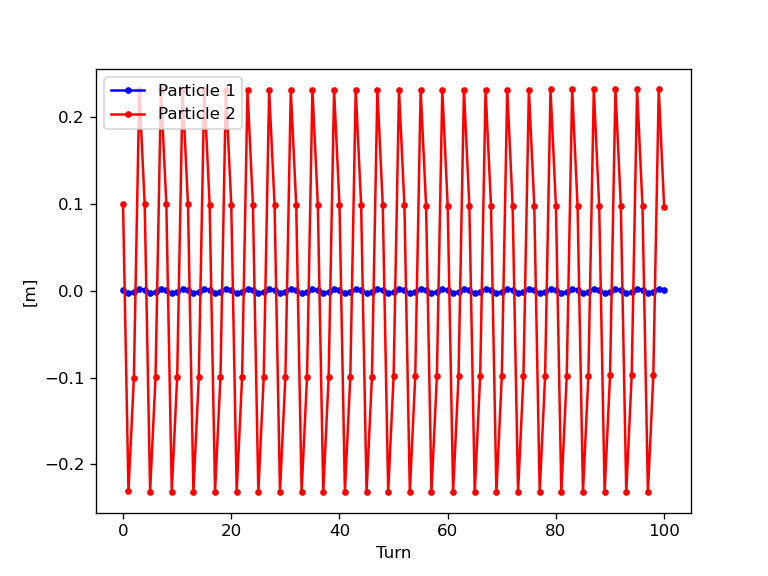

In [93]:
# We can also plot the amplitude of the particle vs the turn number
# Plot visualization options
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

plt.plot(particle1['turn'],particle1['x'],'.-b', label='Particle 1')
plt.plot(particle2['turn'],particle2['x'],'.-r', label='Particle 2')
plt.xlabel('Turn')
plt.ylabel('[m]');
plt.legend(loc='best');

<IPython.core.display.Javascript object>


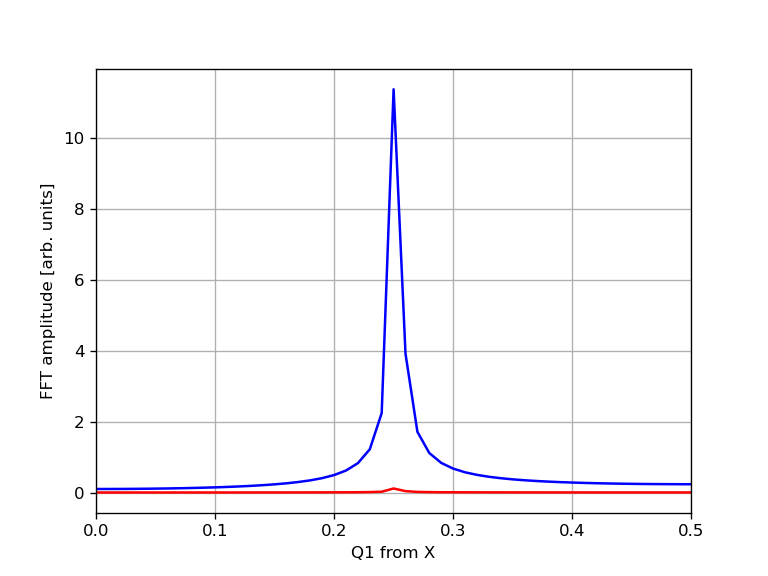

In [94]:
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

# The amplitude of the FFT of the particle amplitude oscilations gives as a mesure of the tune
# Just play with an FFT on 
plt.figure()
plt.plot(np.linspace(0,1,len(particle1['x'])), np.abs(np.fft.fft(particle1['x'])), 'r')
plt.plot(np.linspace(0,1,len(particle2['x'])), np.abs(np.fft.fft(particle2['x'])), 'b')
plt.xlabel('Q1 from X')
plt.ylabel('FFT amplitude [arb. units]');
plt.xlim(0,0.5)# The max. possible frequency for a given sampling rate that can be reconstruct is given by the Nyquist limit= sampling frecuency/2. In our case the sampling rate is 1, so the limit is 0.5.
plt.grid()

Answer: We obtain a similar plot as before but with larger amplitues.

# Track off-momentum

6. Repeat point 4 adding DELTAP=1e-2 to the track command. How does the phase space look now? Is the tune still same? It may help to look only at the first 4 turns to get a clearer picture.

In [95]:
myString='''
//*************************************************//
!   TRACKING
//*************************************************//

track,dump,file='linear_machine_off_energy', DELTAP=0.01;
start, x= 1e-3, px=0, y= 1e-3, py=0;
start, x= 1e-1, px=0, y= 1e-1, py=0;
run,turns=100;
endtrack;

'''
myMad.input(myString);

enter TRACK module
track_deltap:               0.01
  
iteration:   1 error:   2.167827E-02 deltap:   1.000000E-02
orbit:   2.246079E-02  3.258125E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   3.469447E-18 deltap:   1.000000E-02
orbit:   2.246079E-02  3.258125E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: tracksumm

    number       turn                  x                 px 
         1          0              0.001                  0 
         2          0                0.1                  0 
         1        100     0.002203455104    4.799158225e-05 
         2        100       0.1739745046     0.003676719045 

                 y                 py                  t                 pt 
             0.001                  0                  0     0.009999999911 
               0.1                  0                  0     0.009999999911 
  -0.0008592159649     3.66337874e-05     -0.05480041211     0.009999999911

In [96]:
off_momentum_particle1=myMad.table['track.obs0001.p0001'].dframe()
off_momentum_particle2=myMad.table['track.obs0001.p0002'].dframe()

<IPython.core.display.Javascript object>


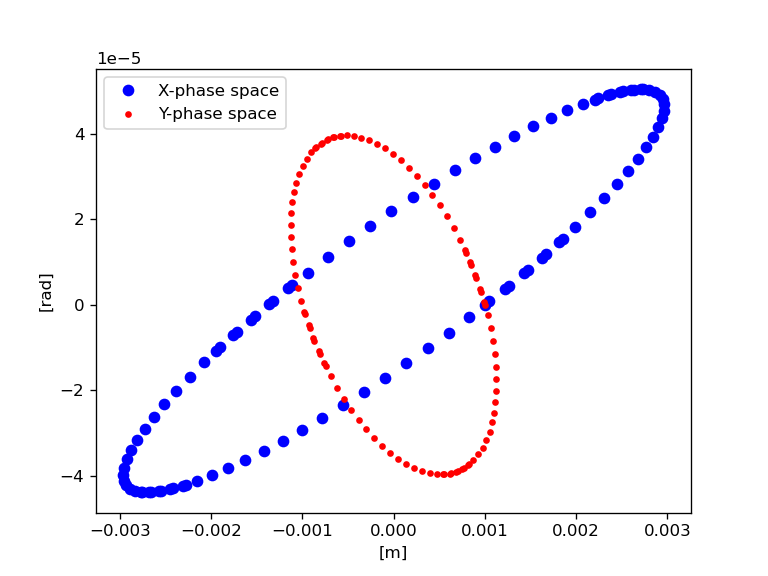

In [97]:
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

plt.plot(off_momentum_particle1['x'],off_momentum_particle1['px'],'ob',label='X-phase space')
plt.plot(off_momentum_particle1['y'],off_momentum_particle1['py'],'.r',label='Y-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')

As we track off-momentum particles the tune is afected by the natural chromaticity of the FODO and it is not 0.25 anymore.

<IPython.core.display.Javascript object>


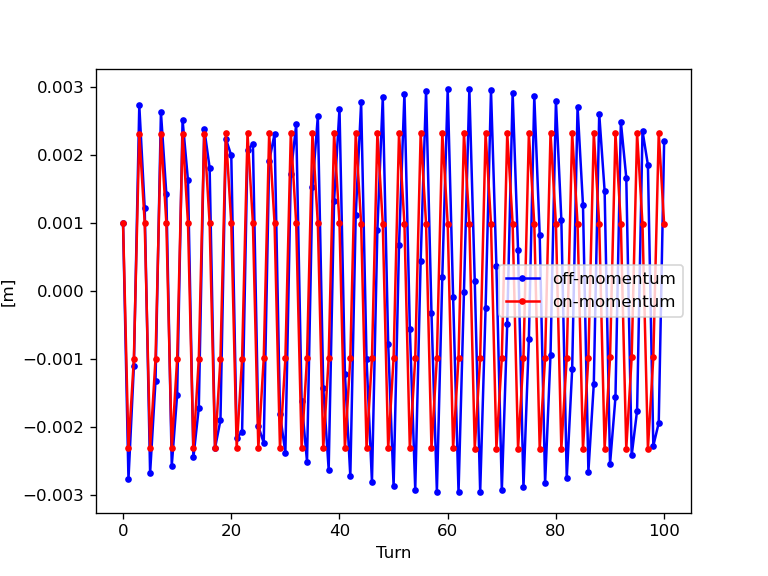

In [98]:
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

plt.plot(off_momentum_particle1['turn'],off_momentum_particle1['x'],'.-b', label='off-momentum')
plt.plot(particle1['turn'],particle1['x'],'.-r', label='on-momentum')
plt.xlabel('Turn')
plt.ylabel('[m]');
plt.legend(loc='best');

<IPython.core.display.Javascript object>


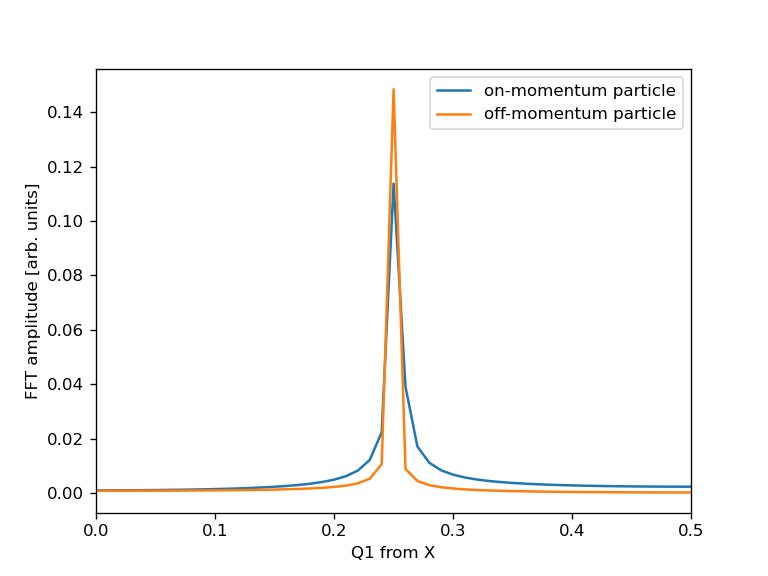

In [99]:
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

plt.plot(np.linspace(0,1,len(particle1['x'])), np.abs(np.fft.fft(particle1['x'])),label="on-momentum particle")
plt.plot(np.linspace(0,1,len(off_momentum_particle1['x'])), np.abs(np.fft.fft(off_momentum_particle1['x'])),label="off-momentum particle")
plt.xlim(0,.5)
plt.xlabel('Q1 from X')
plt.ylabel('FFT amplitude [arb. units]');
plt.legend()

In real machines, with more and stronger quadrupoles the impact could be higher and correction schemes are required. This is what we are going to see in the next tutorial.